In [1]:
import time
import matplotlib.pyplot as plt

In [2]:
res_dict = {}

In [3]:
start = time.perf_counter()
!mpiexec -n 1 python main.py -s 360
end = time.perf_counter()
res_dict['1'] = end - start

Matrix size: 360x360
Processor grid: 1x1
Block size: 360x360

Test with NumPy: Results match.


In [4]:
start = time.perf_counter()
!mpiexec -n 4 python main.py -s 360
end = time.perf_counter()
res_dict['4'] = end - start

Matrix size: 360x360
Processor grid: 2x2
Block size: 180x180

Test with NumPy: Results match.


In [5]:
start = time.perf_counter()
!mpiexec -n 9 python main.py -s 360
end = time.perf_counter()
res_dict['9'] = end - start

Matrix size: 360x360
Processor grid: 3x3
Block size: 120x120

Test with NumPy: Results match.


In [6]:
for k, v in res_dict.items():
    print(f"Time (num_processes={k}): {v:.2f} seconds.")

Time (num_processes=1): 12.57 seconds.
Time (num_processes=4): 4.21 seconds.
Time (num_processes=9): 2.85 seconds.


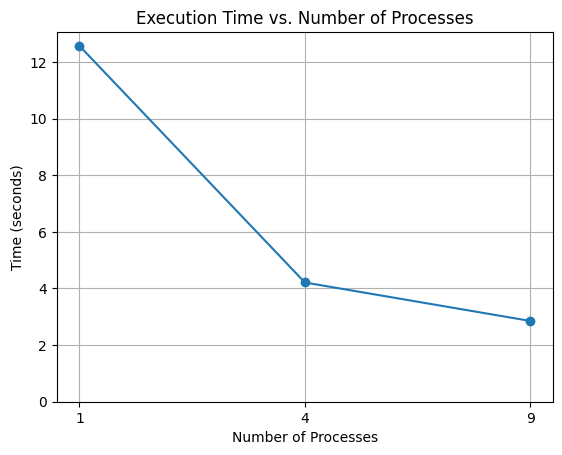

In [7]:
num_processes = list(res_dict.keys())
times = list(res_dict.values())

plt.plot(num_processes, times, marker='o')
plt.xlabel('Number of Processes')
plt.ylabel('Time (seconds)')
plt.title('Execution Time vs. Number of Processes')
plt.ylim(bottom=0)
plt.grid(True)
plt.show()